In [60]:
import numpy as np 
import scipy
print(np.__version__)
print(scipy.__version__)
import tqdm
import pandas as pd
import exoplanet
import astropy 
import pymc3
import pymc3_ext
import celerite2
from numpy.linalg import inv, det, solve

import matplotlib.pyplot as plt

1.21.0
1.7.3


## Phase One: White Noise

In [61]:
def partial_mu(t, theta, wrt):
    """
    Unpack parameters and calculate all partial derivatives of the model w.r.t. those parameters
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    - wrt: parameter with respect to which the model's partial derivative is taken
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - derivative vector of length N
    """

    # unpack parameters
    K, P, T0 = theta[0], theta[1], theta[2]
    
    # calculate partial derivative depending on 'wrt'
    normalized_t = t-T0
    arg = (2*np.pi/P) * normalized_t
    
    if wrt=='K':
        return -np.sin(arg)
    elif wrt=='P':
        return -K * np.cos(arg) * arg/P
    elif wrt=='T0':
        return (2*np.pi*K/P) * np.cos(arg)
    
    print("parameter not recognized")
    
    return                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

def calculate_fim(t, sigma, theta):
    """
    Calculate the generalized Fisher Information Matrix according to I_m,n in 
    https://en.wikipedia.org/wiki/Fisher_information#Multivariate_normal_distribution
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - sigma: RV measurement uncertainties associated with each observation; np.array of length N [cm/s]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - Fisher Information Matrix: len(theta)xlen(theta) matrix; np.array
    
    """

    #print("partial mu, partial K: ", partial_mu(t, theta, 'K'))
    #print("partial mu, partial P: ", partial_mu(t, theta, 'P'))
    #print("partial mu, partial T0: ", partial_mu(t, theta, 'T0'))
    factor2 = 1/sigma**2
    factor2[factor2 == np.inf] = 0 
    
    fim = np.zeros((len(theta),len(theta)))
    for i in range(len(theta)):
        for j in range(len(theta)):
            #param_i = theta[i]
            #param_j = theta[j]
            wrt_i = param_list[i]
            wrt_j = param_list[j]
            
            factor1 = partial_mu(t, theta, wrt_i)#.reshape((1,4)) # partial derivative of the model wrt row parameter, transposed
            #print(factor1)
            ###factor2 = 1/sigma**2 # inverse of covariance matrix (or just the RV variance if held constant)
            ###factor2[factor2 == np.inf] = 0 # turn infs into zeros (shouldn't it be nans?)
            #print(factor2)
            factor3 = partial_mu(t, theta, wrt_j)#.reshape((4,1)) # partial derivative of the model wrt column parameter
            #print(factor3)
            #print("shapes: ", factor1.shape, factor2.shape, factor3.shape)
            #print(np.dot(np.dot(factor1, factor2), factor3))
            
            fim[i][j] = np.dot(np.dot(factor1, factor2), factor3)
    
    return fim

In [75]:
# priors
param_list = ['K','P','T0']
test_T0 = 2360 # BJD
test_K = 500 # 5 m/s to 500 cm/s; it worked for 10000 cm/s
test_P = 10 # days

test_theta = [test_K, test_P, test_T0]

def make_t(n_obs, cadence, start):
    """
    Gemerate observation times given a number of observations and an average cadence (every X nights)
    
    Input: 
    - n_obs: number of observations to try
    - cadence: amount of time between observations [days]
    - start: start time [BJD]
    
    Output:
    - observation times: ndarray
    
    """
    
    ### make a t using n_obs and cadence
    # initial obs time of 2300 is a placeholder that's set as somewhat close to the arbitrary test_T0 of 2360
    end = start + n_obs * cadence 
    t = np.linspace(2300, end, n_obs)
    
    # add jitter ~ N(0, 1 hr) to timestamps
    t += np.random.normal(0, 1./24)

    return t

def strategy(start, n_obs, cadence, theta, sigma_val):
    """
    Allows user to try different n_obs and cadences and visualize how that affects the expected RV semi-amplitude uncertainty, sigma_K
    
    Input: 
    - start: start time from which I build out n_obs * cadence
    - n_obs: number of observations to try
    - cadence: amount of time between observations [days]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    - sigma_val: RV measurement uncertainties associated with each observation; float64 [cm/s]
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - sigma_ks: array of sigma_k's calculated by np.linalg.inv [cm/s]
    - sigma_ks_stable: array of sigma_k's calculated by 1/np.sqrt(FIM[0][0])
    
    """
    
    ### make a t using n_obs and cadence
    # initial obs time of 2300 is a placeholder that's set as somewhat close to the arbitrary test_T0 of 2360
    t = make_t(n_obs, cadence, start)
    #print("time steps: ", t)
    
    # perturb sigma_val to guard against numerical instabilities
    sigma_val += 1e-6
    
    sigma = np.diag(np.ones(len(t))*sigma_val) # cm/s
    
    fim = calculate_fim(t, sigma, theta)
    #print("FIM: ", fim)
    #print("det: ", det(fim))
    inv_fim = inv(fim)
    #print("inv: ", inv_fim)
    sigma_k = np.sqrt(inv_fim)[0][0]
    #print("sigma_K, using inv: ", sigma_k)
    #sigma_ks.append(sigma_k)
    sigma_k_stable = np.sqrt(1/fim[0][0])
    #print("sigma_K, not using inv: ", sigma_k_stable)
    
    # np.linalg.solve is more stable than np.linalg.inv, apparently
    inv_fim_solve = solve(fim, np.diag(np.ones(len(theta)))) 
    sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]
    
    return sigma_k, sigma_k_stable, sigma_k_solve, fim

strategy(start=2352, n_obs=100, cadence=1, theta=test_theta, sigma_val=30) # default to 2300

/tmp/ipykernel_3161572/564434563.py:60: RuntimeWarning: divide by zero encountered in true_divide
  factor2 = 1/sigma**2
/tmp/ipykernel_3161572/1158359634.py:70: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/tmp/ipykernel_3161572/1158359634.py:78: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]


(4.249888360483794,
 4.249669477031456,
 4.249888360483794,
 array([[ 5.53719340e-02,  5.93794896e-01, -1.58837470e-01],
        [ 5.93794896e-01,  1.21852905e+05, -8.49281413e+03],
        [-1.58837470e-01, -8.49281413e+03,  5.50123554e+03]]))

#### Let's generate lots of different strategies using a variety of combinations of n_obs and cadences. 

In [76]:
# priors
param_list = ['K','P','T0']
test_T0 = 2360 # BJD
test_K = 500 # 5 m/s to 500 cm/s; it worked for 10000 cm/s
test_P = 10 # days
test_theta = [test_K, test_P, test_T0]

dim = 100

### try different numbers of total observations made
n_observations = np.linspace(3, 102, dim).astype(int)

### try different observing cadences
### lower bound
# Arjun Savel (thanks, Arjun!) says that 0.6 days is generally considered the minimum (why?)
# Nyquist sampling says halve that to 0.3 days
# Nyquist sampling says the minimum number of observations you need to confirm periodicity is 2
# See wikipedia page for 'Nyquist rate'

### upper bound
# TESS planets generally have max period of 13.7 days
# again, due to Nyquist, halve it to 6.85 days
cadences = np.linspace(0.30, 6.85, dim)
sigma_ks = np.ones(dim**2).reshape((dim,dim))
sigma_ks_stable = np.ones(dim**2).reshape((dim,dim))
sigma_ks_solve = np.ones(dim**2).reshape((dim,dim))

#with tqdm.tqdm(total=100) as pbar:
for enum_i, i in enumerate(n_observations):
    for enum_j, j in enumerate(cadences):
        #print(i, j)
        sigma_k, sigma_k_stable, sigma_k_solve, fim = strategy(start=2300, n_obs=i, cadence=j, theta=test_theta, sigma_val=30)
        #print(sigma_k, sigma_k_stable)
        
        ### EDIT: as shown later, I needed to find out why some sigma_k's were blowing up
        ### Could it be aliasing, as suggested by the spacing of the yellow patches?
        ### Nope. Turns out, as shown directly below, that it's a numerical stability issue.
        ### To show this, I output an example FIM whose sigma_k term blows up.
        ### I compare its np.lingalg.inv() sigma_k against the one calculated by np.sqrt(1/FIM[0][0]).
        if (enum_i==70 and enum_j==70):
            bad_fim = fim

        sigma_ks[enum_i][enum_j] = sigma_k
        sigma_ks_stable[enum_i][enum_j] = sigma_k_stable
        sigma_ks_solve[enum_i][enum_j] = sigma_k_solve


/tmp/ipykernel_3161572/564434563.py:60: RuntimeWarning: divide by zero encountered in true_divide
  factor2 = 1/sigma**2
/tmp/ipykernel_3161572/1158359634.py:70: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/tmp/ipykernel_3161572/1158359634.py:78: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]


In [77]:
print(bad_fim)
print(det(bad_fim))
print(inv(bad_fim))
print(solve(bad_fim, np.diag(np.ones(3))))
print("np.linalg.inv sigma_k: ", np.sqrt(inv(bad_fim)[0][0]))

print("analytic sigma_k: ", np.sqrt(1/bad_fim[0][0]))

print("np.linalg.solve sigma_k: ", np.sqrt(solve(bad_fim, np.diag(np.ones(3)))[0][0]))

[[ 2.13829711e-05  4.20341635e+00 -4.08341019e-01]
 [ 4.20341635e+00  2.04140904e+06 -9.60662624e+04]
 [-4.08341019e-01 -9.60662624e+04  8.00323484e+03]]
5.429733147910834e-06
[[1.30929993e+15 1.02893958e+09 7.91538994e+10]
 [1.02893958e+09 8.08612780e+02 6.22046775e+04]
 [7.91538994e+10 6.22046775e+04 4.78525941e+06]]
[[1.30929993e+15 1.02893958e+09 7.91538994e+10]
 [1.02893958e+09 8.08612780e+02 6.22046775e+04]
 [7.91538994e+10 6.22046775e+04 4.78525941e+06]]
np.linalg.inv sigma_k:  36184249.70887748
analytic sigma_k:  216.25490924197237
np.linalg.solve sigma_k:  36184249.70887748


Welp. Looks like the numerical stability issues continue past the low-n_obs regimes. 

Furthermore, it looks like there's no difference between using np.linalg.inv(FIM) and np.linalg.solve(FIM, I). I tried this for both i, j = 70, 70 (worse; misbehaving bc of aliasing) and i, j = 68, 20 (bad; misbehaving because of...numerical instability?).

In [65]:
sigma_ks_stable.shape

(100, 100)

In [66]:
n_observations

array([  3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
        55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
        68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
        81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
        94,  95,  96,  97,  98,  99, 100, 101, 102])

In [67]:
cadences

array([0.3       , 0.36616162, 0.43232323, 0.49848485, 0.56464646,
       0.63080808, 0.6969697 , 0.76313131, 0.82929293, 0.89545455,
       0.96161616, 1.02777778, 1.09393939, 1.16010101, 1.22626263,
       1.29242424, 1.35858586, 1.42474747, 1.49090909, 1.55707071,
       1.62323232, 1.68939394, 1.75555556, 1.82171717, 1.88787879,
       1.9540404 , 2.02020202, 2.08636364, 2.15252525, 2.21868687,
       2.28484848, 2.3510101 , 2.41717172, 2.48333333, 2.54949495,
       2.61565657, 2.68181818, 2.7479798 , 2.81414141, 2.88030303,
       2.94646465, 3.01262626, 3.07878788, 3.14494949, 3.21111111,
       3.27727273, 3.34343434, 3.40959596, 3.47575758, 3.54191919,
       3.60808081, 3.67424242, 3.74040404, 3.80656566, 3.87272727,
       3.93888889, 4.00505051, 4.07121212, 4.13737374, 4.20353535,
       4.26969697, 4.33585859, 4.4020202 , 4.46818182, 4.53434343,
       4.60050505, 4.66666667, 4.73282828, 4.7989899 , 4.86515152,
       4.93131313, 4.99747475, 5.06363636, 5.12979798, 5.19595

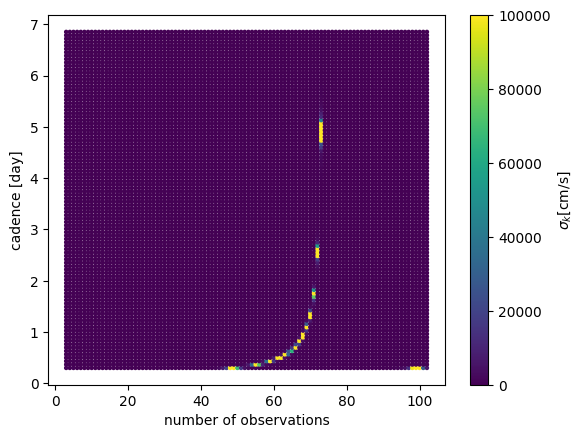

In [78]:
x, y = np.meshgrid(n_observations, cadences)
plt.scatter(x, y, c=sigma_ks, s=5, vmin=0, vmax=100000)
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"$\sigma_k$[cm/s]")
plt.xlabel("number of observations")
plt.ylabel("cadence [day]")
#plt.savefig("plots/n_obs-cadence-sigma_k.pdf", format="pdf")
plt.show()

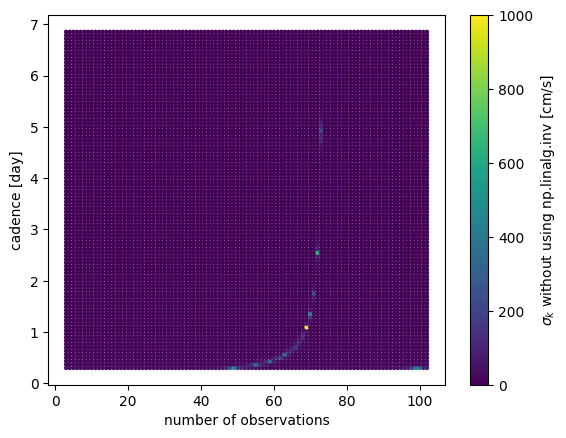

In [79]:
x, y = np.meshgrid(n_observations, cadences)
plt.scatter(x, y, c=sigma_ks_stable, s=5, vmin=0, vmax=1000)
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"$\sigma_k$ without using np.linalg.inv [cm/s]")
plt.xlabel("number of observations")
plt.ylabel("cadence [day]")
#plt.savefig("plots/n_obs-cadence-sigma_k-stable.pdf", format="pdf")
plt.show()

### Are these yellow bands and dots products of bugs or actual indicators of aliasing? 

a) Let's plot a model and see how the "yellow" strategy observations fall compared to the time series, versus a "purple" strategy. 

b) Let's marginalize over all start times (what  would that range look like?) and stack the images on top of each other. I should expect the yellow artifacts to smooth out.

c) After doing a), let's also add stochasticity to the sampling of the RV observations. That is, do np.linspace()+noise term drawn from a Gaussian with spread of 1 hour. 

#### a) Are my observations actually aliasing my fake RV time series? 

In [93]:
def model(t, sigma, theta): 
    """
    Radial velocity model, given timestamps and planetary orbital parameters
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - sigma: RV measurement uncertainties associated with each observation; np.array of length N [cm/s]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]

    """
    
    K, P, T0 = theta[0], theta[1], theta[2]
    arg = (2*np.pi/P)*(t-T0)
    rv = -K * np.sin(arg)
    
    # instead of returning exact, gridded obs times, let's add some stochasticitiy to it
    # draw from Gaussian with spread of 1 hour
    #return rv+np.random.normal(0, 1./24)
    return rv

In [94]:
np.argmax(sigma_ks)

1266

In [95]:
# arbitrary row, yellow streak column
print(sigma_ks[50][10]) 
print(sigma_ks_stable[50][10]) 
print("cadences: ", cadences[50])
print("n_obs: ", n_observations[10])

5.903434823862581
5.90188180493554
cadences:  3.6080808080808078
n_obs:  13


In [88]:
y[0:8]

array([-7.34788079e-13, -3.14266450e+01, -6.27290151e+01, -9.37833267e+01,
       -1.24466777e+02, -1.54658031e+02, -1.84237697e+02, -2.13088806e+02])

In [96]:
start = 2300 # BJD
end = 2400 # BJD
test_t = np.linspace(start, end, 1000)
test_t_phase_folded = test_t % test_P
sigma_val = 30 # cm/s
test_sigma = np.ones(len(test_t))*sigma_val
y = model(test_t, test_sigma, test_theta)
y[0:8]

array([-7.34788079e-13, -3.14266450e+01, -6.27290151e+01, -9.37833267e+01,
       -1.24466777e+02, -1.54658031e+02, -1.84237697e+02, -2.13088806e+02])

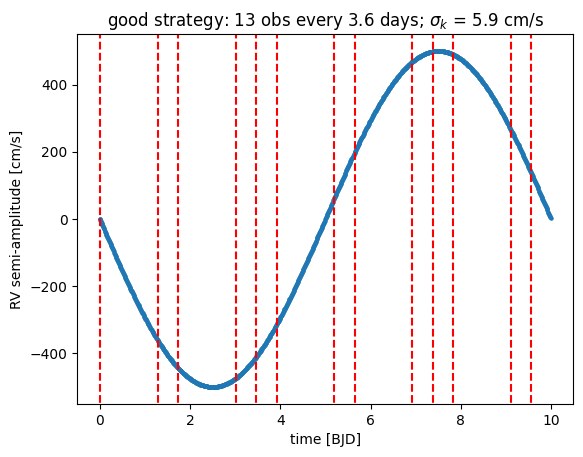

In [101]:
start = 2300 # BJD
end = 2400 # BJD
test_t = np.linspace(start, end, 1000)
test_t_phase_folded = test_t % test_P
sigma_val = 30+1e-6 # cm/s
test_sigma = np.ones(len(test_t))*sigma_val
y = model(test_t, test_sigma, test_theta)
y_phase_folded = model(test_t_phase_folded, test_sigma, test_theta)

end = start + cadences[50]*n_observations[10]
good_strat = np.linspace(2300, end, n_observations[10]) + np.random.normal(0, 1./24)
good_strat_phase_folded = good_strat % test_P

plt.scatter(test_t_phase_folded, y_phase_folded, s=5)
#for i in good_strat:
for i in good_strat_phase_folded:
    plt.axvline(i, min(y_phase_folded), max(y_phase_folded), linestyle='--', c='r')
plt.xlabel('time [BJD]')
plt.ylabel('RV semi-amplitude [cm/s]')
plt.title(r'good strategy: 13 obs every 3.6 days; ${\sigma}_k$ = 5.9 cm/s')
plt.savefig('plots/good-strategy-rv.pdf', format='pdf')
plt.show()

In [98]:
# arbitrary row, yellow streak column
print(sigma_ks[20][68]) 
print(sigma_ks_stable[20][68]) 
print("cadences: ", cadences[20])
print("n_obs: ", n_observations[68])
end = start + cadences[20]*n_observations[68]
print(np.linspace(2300, end, n_observations[68]))

15028.55494895998
55.337474389081656
cadences:  1.6232323232323231
n_obs:  71
[2300.         2301.64642136 2303.29284271 2304.93926407 2306.58568543
 2308.23210678 2309.87852814 2311.52494949 2313.17137085 2314.81779221
 2316.46421356 2318.11063492 2319.75705628 2321.40347763 2323.04989899
 2324.69632035 2326.3427417  2327.98916306 2329.63558442 2331.28200577
 2332.92842713 2334.57484848 2336.22126984 2337.8676912  2339.51411255
 2341.16053391 2342.80695527 2344.45337662 2346.09979798 2347.74621934
 2349.39264069 2351.03906205 2352.68548341 2354.33190476 2355.97832612
 2357.62474747 2359.27116883 2360.91759019 2362.56401154 2364.2104329
 2365.85685426 2367.50327561 2369.14969697 2370.79611833 2372.44253968
 2374.08896104 2375.7353824  2377.38180375 2379.02822511 2380.67464646
 2382.32106782 2383.96748918 2385.61391053 2387.26033189 2388.90675325
 2390.5531746  2392.19959596 2393.84601732 2395.49243867 2397.13886003
 2398.78528139 2400.43170274 2402.0781241  2403.72454545 2405.37096681


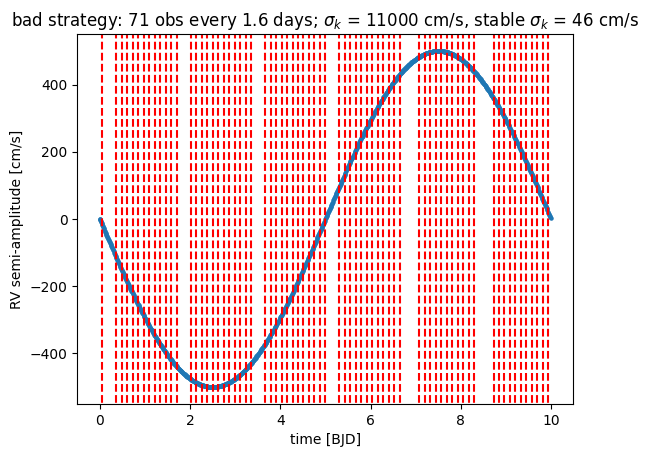

In [103]:
start = 2300 # BJD
end = 2400 # BJD
test_t = np.linspace(start, end, 1000)
test_t_phase_folded = test_t % test_P
sigma_val = 30 + 1e-6 # cm/s
#sigma_val = 30 # cm/s
test_sigma = np.ones(len(test_t))*sigma_val
y = model(test_t, test_sigma, test_theta)
y_phase_folded = model(test_t_phase_folded, test_sigma, test_theta)

end = start + cadences[20]*n_observations[68]
bad_strat = np.linspace(2300, end, n_observations[68]) + np.random.normal(0, 1./24)
bad_strat_phase_folded = bad_strat % test_P

plt.scatter(test_t_phase_folded, y_phase_folded, s=5)
#for i in good_strat:
for i in bad_strat_phase_folded:
    plt.axvline(i, min(y_phase_folded), max(y_phase_folded), linestyle='--', c='r')
plt.xlabel('time [BJD]')
plt.ylabel('RV semi-amplitude [cm/s]')
plt.title(r'bad strategy: 71 obs every 1.6 days; ${\sigma}_k$ = 11000 cm/s, stable ${\sigma}_k$ = 46 cm/s') # 110000 
plt.savefig('plots/bad-strategy-rv.pdf', format='pdf')
plt.show()

8.766592729531533
8.053345177087733
cadences:  1.6232323232323231
n_obs:  73
[2300.         2301.64577722 2303.29155443 2304.93733165 2306.58310887
 2308.22888608 2309.8746633  2311.52044052 2313.16621773 2314.81199495
 2316.45777217 2318.10354938 2319.7493266  2321.39510382 2323.04088103
 2324.68665825 2326.33243547 2327.97821268 2329.6239899  2331.26976712
 2332.91554433 2334.56132155 2336.20709877 2337.85287598 2339.4986532
 2341.14443042 2342.79020763 2344.43598485 2346.08176207 2347.72753928
 2349.3733165  2351.01909371 2352.66487093 2354.31064815 2355.95642536
 2357.60220258 2359.2479798  2360.89375701 2362.53953423 2364.18531145
 2365.83108866 2367.47686588 2369.1226431  2370.76842031 2372.41419753
 2374.05997475 2375.70575196 2377.35152918 2378.9973064  2380.64308361
 2382.28886083 2383.93463805 2385.58041526 2387.22619248 2388.8719697
 2390.51774691 2392.16352413 2393.80930135 2395.45507856 2397.10085578
 2398.746633   2400.39241021 2402.03818743 2403.68396465 2405.32974186
 2

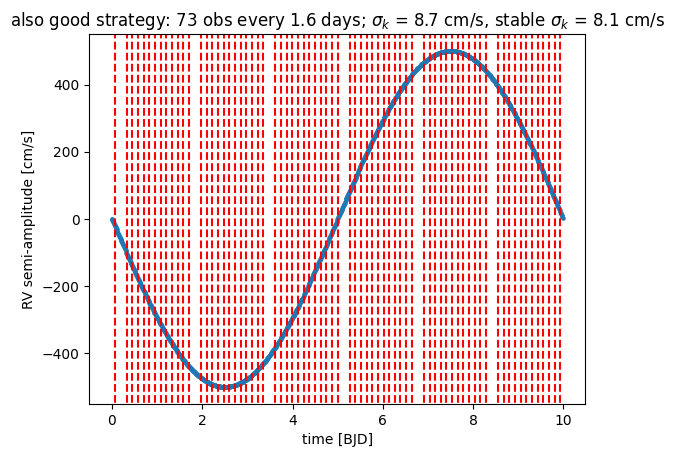

In [104]:
# arbitrary row, yellow streak column
print(sigma_ks[20][70]) 
print(sigma_ks_stable[20][70]) 
print("cadences: ", cadences[20])
print("n_obs: ", n_observations[70])
end = start + cadences[20]*n_observations[70]
print(np.linspace(2300, end, n_observations[70]))

end = start + cadences[20]*n_observations[70]
strat = np.linspace(2300, end, n_observations[70]) + np.random.normal(0, 1./24)
strat_phase_folded = strat % test_P

plt.scatter(test_t_phase_folded, y_phase_folded, s=5)
#for i in good_strat:
for i in strat_phase_folded:
    plt.axvline(i, min(y_phase_folded), max(y_phase_folded), linestyle='--', c='r')
plt.xlabel('time [BJD]')
plt.ylabel('RV semi-amplitude [cm/s]')
plt.title(r'also good strategy: 73 obs every 1.6 days; ${\sigma}_k$ = 8.7 cm/s, stable ${\sigma}_k$ = 8.1 cm/s')
plt.savefig('plots/also-good-strategy-rv.pdf', format='pdf')
plt.show()

In [105]:
# arbitrary row, yellow streak column
column = 32
row = 70
print(sigma_ks[column][row]) 
print("cadences: ", cadences[column])
print("n_obs: ", n_observations[row])
end = start + cadences[column]*n_observations[row]
print(np.linspace(2300, end, n_observations[row]))

15.229635397321646
cadences:  2.417171717171717
n_obs:  73
[2300.         2302.45074355 2304.90148709 2307.35223064 2309.80297419
 2312.25371773 2314.70446128 2317.15520483 2319.60594837 2322.05669192
 2324.50743547 2326.95817901 2329.40892256 2331.85966611 2334.31040965
 2336.7611532  2339.21189675 2341.66264029 2344.11338384 2346.56412738
 2349.01487093 2351.46561448 2353.91635802 2356.36710157 2358.81784512
 2361.26858866 2363.71933221 2366.17007576 2368.6208193  2371.07156285
 2373.5223064  2375.97304994 2378.42379349 2380.87453704 2383.32528058
 2385.77602413 2388.22676768 2390.67751122 2393.12825477 2395.57899832
 2398.02974186 2400.48048541 2402.93122896 2405.3819725  2407.83271605
 2410.2834596  2412.73420314 2415.18494669 2417.63569024 2420.08643378
 2422.53717733 2424.98792088 2427.43866442 2429.88940797 2432.34015152
 2434.79089506 2437.24163861 2439.69238215 2442.1431257  2444.59386925
 2447.04461279 2449.49535634 2451.94609989 2454.39684343 2456.84758698
 2459.29833053 246

In [106]:
test_sigmas = []
for columns in range(100):
    test_sigmas.append(sigma_ks[columns][row])
    #print(sigma_ks[columns][row])
print(np.argmax(test_sigmas))

70


In [107]:
print(sigma_ks[70][70])
print(sigma_ks_stable[70][70])
print("cadences: ", cadences[70])
print("n_obs: ", n_observations[70])

36184249.70887748
216.25490924197237
cadences:  4.93131313131313
n_obs:  73


In [108]:
strat

array([2300.05933086, 2301.70510808, 2303.3508853 , 2304.99666251,
       2306.64243973, 2308.28821695, 2309.93399416, 2311.57977138,
       2313.2255486 , 2314.87132581, 2316.51710303, 2318.16288025,
       2319.80865746, 2321.45443468, 2323.1002119 , 2324.74598911,
       2326.39176633, 2328.03754355, 2329.68332076, 2331.32909798,
       2332.9748752 , 2334.62065241, 2336.26642963, 2337.91220685,
       2339.55798406, 2341.20376128, 2342.8495385 , 2344.49531571,
       2346.14109293, 2347.78687015, 2349.43264736, 2351.07842458,
       2352.7242018 , 2354.36997901, 2356.01575623, 2357.66153345,
       2359.30731066, 2360.95308788, 2362.5988651 , 2364.24464231,
       2365.89041953, 2367.53619675, 2369.18197396, 2370.82775118,
       2372.4735284 , 2374.11930561, 2375.76508283, 2377.41086005,
       2379.05663726, 2380.70241448, 2382.3481917 , 2383.99396891,
       2385.63974613, 2387.28552335, 2388.93130056, 2390.57707778,
       2392.222855  , 2393.86863221, 2395.51440943, 2397.16018

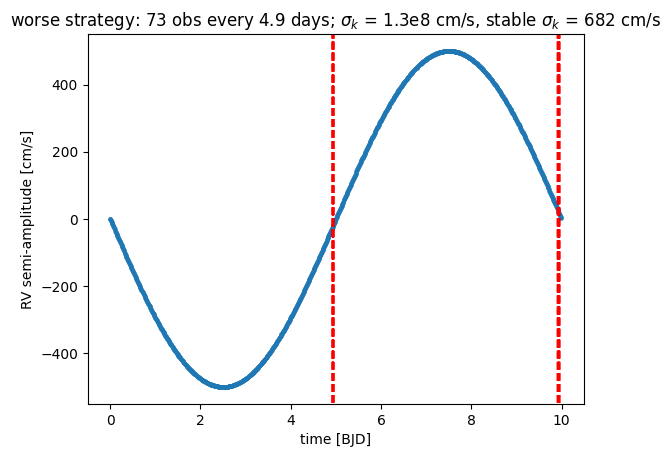

In [111]:
start = 2300 # BJD
end = 2400 # BJD
test_t = np.linspace(start, end, 1000)
test_t_phase_folded = test_t % test_P
sigma_val = 30+1e-6 # cm/s
test_sigma = np.ones(len(test_t))*sigma_val
y = model(test_t, test_sigma, test_theta)
y_phase_folded = model(test_t_phase_folded, test_sigma, test_theta)

end = start + cadences[70]*n_observations[70]
strat = np.linspace(2300, end, n_observations[70]) + np.random.normal(0, 1./24)
strat_phase_folded = strat % test_P

plt.scatter(test_t_phase_folded, y_phase_folded, s=5)
#for i in good_strat:
for i in strat_phase_folded:
    plt.axvline(i, min(y_phase_folded), max(y_phase_folded), linestyle='--', c='r')
plt.xlabel('time [BJD]')
plt.ylabel('RV semi-amplitude [cm/s]')
plt.title(r'worse strategy: 73 obs every 4.9 days; ${\sigma}_k$ = 1.3e8 cm/s, stable ${\sigma}_k$ = 682 cm/s') # 110000 
plt.savefig('plots/worse-strategy-rv.pdf', format='pdf')
plt.show()

In [112]:
np.unique(strat_phase_folded)

array([4.92710588, 4.9274987 , 4.92789151, 4.92828433, 4.92867715,
       4.92906996, 4.92946278, 4.9298556 , 4.93024842, 4.93064123,
       4.93103405, 4.93142687, 4.93181968, 4.9322125 , 4.93260532,
       4.93299814, 4.93339095, 4.93378377, 4.93417659, 4.9345694 ,
       4.93496222, 4.93535504, 4.93574785, 4.93614067, 4.93653349,
       4.93692631, 4.93731912, 4.93771194, 4.93810476, 4.93849757,
       4.93889039, 4.93928321, 4.93967603, 4.94006884, 4.94046166,
       4.94085448, 9.92690947, 9.92730229, 9.9276951 , 9.92808792,
       9.92848074, 9.92887356, 9.92926637, 9.92965919, 9.93005201,
       9.93044482, 9.93083764, 9.93123046, 9.93162328, 9.93201609,
       9.93240891, 9.93280173, 9.93319454, 9.93358736, 9.93398018,
       9.93437299, 9.93476581, 9.93515863, 9.93555145, 9.93594426,
       9.93633708, 9.9367299 , 9.93712271, 9.93751553, 9.93790835,
       9.93830117, 9.93869398, 9.9390868 , 9.93947962, 9.93987243,
       9.94026525, 9.94065807, 9.94105088])

### b) Marginalize over all start times

Add sensitivity maps for start times from 2300 to 2300 plus max(n_obs) times max(cadence)

Let's compare the ostensibly two cases of badness: numerical instability and aliasing. (The third case is that I messed up.)

In [113]:
end = max(n_observations)*max(cadences)
print(end)

698.6999999999999


#### "Bad" because of (possibly) numerical instability

In [55]:
# priors
param_list = ['K','P','T0']
test_T0 = 2360 # BJD
test_K = 500 # 5 m/s to 500 cm/s; it worked for 10000 cm/s
test_P = 10 # days
test_theta = [test_K, test_P, test_T0]

dim = 100

### try different numbers of total observations made
n_observations = np.linspace(3, 102, dim).astype(int)

### try different observing cadences
### lower bound
# Arjun Savel (thanks, Arjun!) says that 0.6 days is generally considered the minimum (why?)
# Nyquist sampling says halve that to 0.3 days
# Nyquist sampling says the minimum number of observations you need to confirm periodicity is 2
# See wikipedia page for 'Nyquist rate'

### upper bound
# TESS planets generally have max period of 13.7 days
# again, due to Nyquist, halve it to 6.85 days
cadences = np.linspace(0.30, 6.85, dim)

#with tqdm.tqdm(total=100) as pbar:
starts = np.linspace(2300, 2300+test_P, 200)
sigma_ks_all = np.ones(dim**2).reshape((dim,dim))
sigma_ks_stable_all = np.ones(dim**2).reshape((dim,dim))
sigma_ks_solve_all = np.ones(dim**2).reshape((dim,dim))
    
for start in starts: 
    sigma_ks = np.ones(dim**2).reshape((dim,dim))
    sigma_ks_stable = np.ones(dim**2).reshape((dim,dim))
    sigma_ks_solve = np.ones(dim**2).reshape((dim,dim))

    for enum_i, i in enumerate(n_observations):
        for enum_j, j in enumerate(cadences):
            #print(i, j)
            try:
                sigma_k, sigma_k_stable, sigma_k_solve, fim = strategy(start=start, n_obs=i, cadence=j, theta=test_theta, sigma_val=30)
            except Exception as e:
                print(e, ", culprit: ", start, i, j)
            #print(sigma_k, sigma_k_stable)

            ### EDIT: as shown later, I needed to find out why some sigma_k's were blowing up
            ### Could it be aliasing, as suggested by the spacing of the yellow patches?
            ### Nope. Turns out, as shown directly below, that it's a numerical stability issue.
            ### To show this, I output an example FIM whose sigma_k term blows up.
            ### I compare its np.lingalg.inv() sigma_k against the one calculated by np.sqrt(1/FIM[0][0]).
            #if (enum_i==70 and enum_j==70):
            #    bad_fim = fim

            sigma_ks[enum_i][enum_j] = sigma_k
            sigma_ks_stable[enum_i][enum_j] = sigma_k_stable
            sigma_ks_solve[enum_i][enum_j] = sigma_k_solve

            sigma_ks_all += sigma_ks
            sigma_ks_stable_all += sigma_ks_stable
            sigma_ks_solve_all += sigma_ks_solve
            

/tmp/ipykernel_3161572/564434563.py:60: RuntimeWarning: divide by zero encountered in true_divide
  factor2 = 1/sigma**2
/tmp/ipykernel_3161572/3487445076.py:67: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/tmp/ipykernel_3161572/3487445076.py:75: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]


Singular matrix , culprit:  2300.0 15 4.666666666666666
Singular matrix , culprit:  2301.5577889447236 3 2.814141414141414
Singular matrix , culprit:  2301.608040201005 49 4.865151515151514
Singular matrix , culprit:  2301.959798994975 5 3.6080808080808078
Singular matrix , culprit:  2302.763819095477 9 4.137373737373737
Singular matrix , culprit:  2305.527638190955 3 1.490909090909091
Singular matrix , culprit:  2306.0804020100504 5 6.783838383838384
Singular matrix , culprit:  2306.1306532663316 6 3.1449494949494947
Singular matrix , culprit:  2306.834170854271 4 5.7914141414141405
Singular matrix , culprit:  2306.934673366834 10 3.806565656565656
Singular matrix , culprit:  2307.5879396984924 3 4.137373737373737
Singular matrix , culprit:  2309.64824120603 3 6.783838383838384


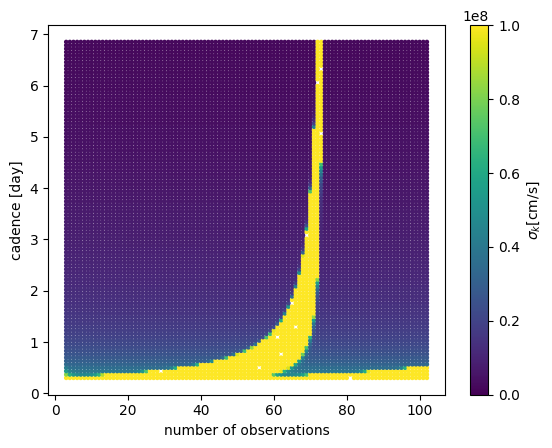

In [116]:
x, y = np.meshgrid(n_observations, cadences)
plt.scatter(x, y, c=sigma_ks_solve_all, s=5, vmin=0, vmax=1e8)
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"$\sigma_k$[cm/s]")
plt.xlabel("number of observations")
plt.ylabel("cadence [day]")
plt.savefig("plots/n_obs-cadence-sigma_k-stacked.pdf", format="pdf")
plt.show()

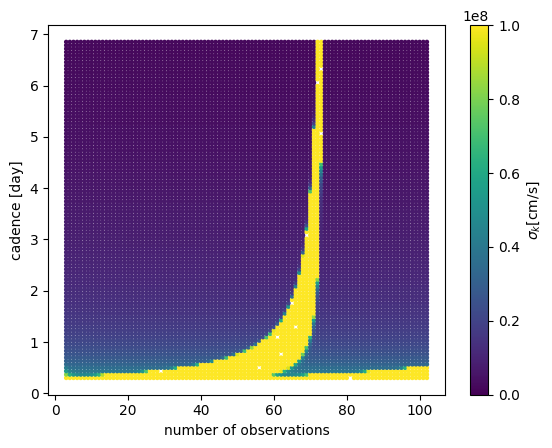

In [115]:
x, y = np.meshgrid(n_observations, cadences)
plt.scatter(x, y, c=sigma_ks_solve_all, s=5, vmin=0, vmax=1e8)
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"$\sigma_k$[cm/s]")
plt.xlabel("number of observations")
plt.ylabel("cadence [day]")
plt.savefig("plots/n_obs-cadence-sigma_k-solve-stacked.pdf", format="pdf")
plt.show()

#### "Bad" because of aliasing

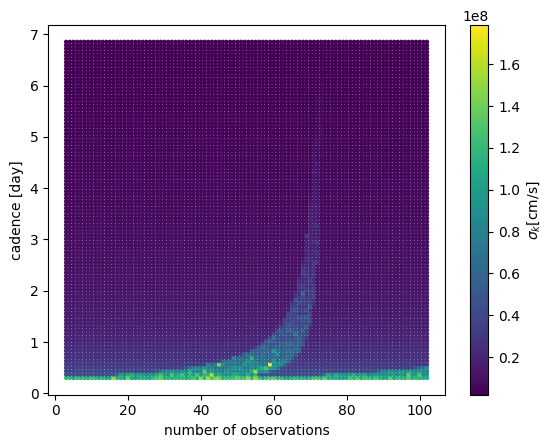

In [114]:
x, y = np.meshgrid(n_observations, cadences)
plt.scatter(x, y, c=sigma_ks_stable_all, s=5)#, vmin=0, vmax=1e15)
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"$\sigma_k$[cm/s]")
plt.xlabel("number of observations")
plt.ylabel("cadence [day]")
#plt.savefig("plots/n_obs-cadence-sigma_k-solve-stacked.pdf", format="pdf")
plt.show()

## Phase 2: Correlated Noise

Let's now add complexity to the covariance matrix, Sigma. Instead of it being just white noise (1/sigma_RV^2), it is now a quasi-periodic GP kernel, with free parameters given by the S-index part of Table 1 in Langellier et al 2020: https://iopscience.iop.org/article/10.3847/1538-3881/abf1e0/meta#ajabf1e0t1

In [121]:
### free parameters from Langellier et al 2020
# let's hold these constant for now, but maybe we should sample from the given uncertainties later?
Tau = 23.6 # active region lifetime; days
eta = 0.58 # smoothing parameter
Prot = 28.1 # solar rotation period; days
sigma_qp_s = 1.43e-3 # correlated noise amplitude
sigma_wn_s = 0.178e-3 # white noise amplitude

def cov_matrix(t, params):
    """
    Build a covariance matrix, Sigma, that will be used in the calculation of the Fisher Information Matrix
    
    Inputs:
    - t: time series of length N observations; np.array [day]
    - Tau: active region lifetime [days]; free param taken from Langellier et al 2020
    - eta: smoothing parameter; free param taken from Langellier et al 2020
    - Prot: rotation period [days]; free param taken from Langellier et al 2020
    - sigma_qp_s: correlated noise amplitude; free param taken from Langellier et al 2020
    - sigma_wn_s: white noise amplitude; free param taken from Langellier et al 2020
    
    Outputs:
    - N by N matrix of covariance elements following Equations 1 & 2 of Langellier et al 2020
    
    """
    
    Tau, eta, Prot, sigma_qp_s, sigma_wn_s = params[0], params[1], params[2], params[3], params[4]
    
    # create N by N matrix, where N is length of observations time series
    k = np.zeros((len(t),len(t)))
    
    for i in range(len(t)):
        for j in range(len(t)):
            term1 = ((t[i]-t[j])**2)/(2*Tau**2)
            term2 = (1/(2*eta**2)) * (np.sin(np.pi * (t[i] - t[j])/Prot))**2
            arg = term1 - term2
            k[i][j] = np.exp(arg)
    
    K = sigma_qp_s**2 * k + sigma_wn_s**2 * np.diag(np.ones(len(t)))
    
    return K

params = [Tau, eta, Prot, sigma_qp_s, sigma_wn_s]
cov_matrix(strat, params)

array([[2.07658400e-06, 1.37681664e-06, 6.72538128e-07, ...,
        2.71922891e+41, 7.98146665e+42, 4.29341131e+44],
       [1.37681664e-06, 2.07658400e-06, 1.37681664e-06, ...,
        2.16264843e+40, 2.71922891e+41, 7.98146665e+42],
       [6.72538128e-07, 1.37681664e-06, 2.07658400e-06, ...,
        2.07271301e+39, 2.16264843e+40, 2.71922891e+41],
       ...,
       [2.71922891e+41, 2.16264843e+40, 2.07271301e+39, ...,
        2.07658400e-06, 1.37681664e-06, 6.72538128e-07],
       [7.98146665e+42, 2.71922891e+41, 2.16264843e+40, ...,
        1.37681664e-06, 2.07658400e-06, 1.37681664e-06],
       [4.29341131e+44, 7.98146665e+42, 2.71922891e+41, ...,
        6.72538128e-07, 1.37681664e-06, 2.07658400e-06]])

Recalculate FIM, replacing scalar sigma_RV with this new covariance matrix. 

In [ ]:
# priors
param_list = ['K','P','T0']
test_T0 = 2360 # BJD
test_K = 500 # 5 m/s to 500 cm/s; it worked for 10000 cm/s
test_P = 10 # days
test_theta = [test_K, test_P, test_T0]

dim = 100

### try different numbers of total observations made
n_observations = np.linspace(3, 102, dim).astype(int)

### try different observing cadences
### lower bound
# Arjun Savel (thanks, Arjun!) says that 0.6 days is generally considered the minimum (why?)
# Nyquist sampling says halve that to 0.3 days
# Nyquist sampling says the minimum number of observations you need to confirm periodicity is 2
# See wikipedia page for 'Nyquist rate'

### upper bound
# TESS planets generally have max period of 13.7 days
# again, due to Nyquist, halve it to 6.85 days
cadences = np.linspace(0.30, 6.85, dim)
sigma_ks = np.ones(dim**2).reshape((dim,dim))
sigma_ks_stable = np.ones(dim**2).reshape((dim,dim))
sigma_ks_solve = np.ones(dim**2).reshape((dim,dim))

#with tqdm.tqdm(total=100) as pbar:
for enum_i, i in enumerate(n_observations):
    for enum_j, j in enumerate(cadences):
        #print(i, j)
        sigma_k, sigma_k_stable, sigma_k_solve, fim = strategy(start=2300, n_obs=i, cadence=j, theta=test_theta, sigma_val=30)
        #print(sigma_k, sigma_k_stable)
        
        ### EDIT: as shown later, I needed to find out why some sigma_k's were blowing up
        ### Could it be aliasing, as suggested by the spacing of the yellow patches?
        ### Nope. Turns out, as shown directly below, that it's a numerical stability issue.
        ### To show this, I output an example FIM whose sigma_k term blows up.
        ### I compare its np.lingalg.inv() sigma_k against the one calculated by np.sqrt(1/FIM[0][0]).
        if (enum_i==70 and enum_j==70):
            bad_fim = fim

        sigma_ks[enum_i][enum_j] = sigma_k
        sigma_ks_stable[enum_i][enum_j] = sigma_k_stable
        sigma_ks_solve[enum_i][enum_j] = sigma_k_solve